## For Libraries Importing


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the Datasets

In [4]:
input_file_path="/home/zoro/ACM Hackathon 2k25/device_data_model_input(device_data).csv"
target_file_path="/home/zoro/ACM Hackathon 2k25/device_data_model_target(poll_params).csv"
met_params_path="/home/zoro/ACM Hackathon 2k25/device_data_model_target(met_params).csv"

In [5]:
input_data=pd.read_csv(input_file_path)
target_data=pd.read_csv(target_file_path)
met_params_data = pd.read_csv(met_params_path)

## Cleaning the Data

In [7]:
# Converting the Timestamps format for Consistency
input_data['dt_time'] = pd.to_datetime(input_data['dt_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')

/tmp/ipykernel_3460/948199282.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
/tmp/ipykernel_3460/948199282.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')


In [8]:
#Dropping Null Values
input_data = input_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
target_data = target_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
met_params_data = met_params_data.dropna(subset=['dt_time']).sort_values('dt_time').reset_index(drop=True)
input_data.info()

#Merging the Data using Nearest Join
merged_data = pd.merge_asof(input_data, target_data, on='dt_time', direction='nearest')
merged_data = pd.merge_asof(merged_data, met_params_data, on='dt_time', direction='nearest')
#Using Linear Interpolation for merging Data
merged_data = merged_data.interpolate(method='linear')
# merged_data = merged_data.ffill().bfill()  

# Sort data chronologically after merging
merged_data = merged_data.sort_values('dt_time').reset_index(drop=True)


# Show merged data info
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15840 entries, 0 to 15839
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dt_time   15840 non-null  datetime64[ns]
 1   op1       15581 non-null  float64       
 2   op2       15581 non-null  float64       
 3   temp      15581 non-null  float64       
 4   humidity  15581 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 618.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15840 entries, 0 to 15839
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dt_time   15840 non-null  datetime64[ns]
 1   op1       15840 non-null  float64       
 2   op2       15840 non-null  float64       
 3   temp      15840 non-null  float64       
 4   humidity  15840 non-null  float64       
 5   ozone     15840 non-null  float64       
 6   ws        15840 non-null  fl

In [9]:
 merged_data

,dt_time,op1,op2,temp,humidity,ozone,ws,wd
0,2024-02-28 00:00:00,261.0,231.0,22.8,63.1,34.75,1.01,344.0
1,2024-02-28 00:01:00,261.0,231.0,22.8,63.1,34.77,3.42,282.5
2,2024-02-28 00:02:00,262.0,231.0,22.8,63.3,34.87,6.78,334.4
3,2024-02-28 00:03:00,261.0,231.0,22.8,63.4,34.92,2.89,17.5
4,2024-02-28 00:04:00,260.0,231.0,22.7,63.5,35.17,2.33,329.0
...,...,...,...,...,...,...,...,...
15835,2024-03-09 23:55:00,264.0,232.0,26.7,48.8,37.50,1.66,329.3
15836,2024-03-09 23:56:00,265.0,232.0,26.7,48.8,37.50,1.66,329.3
15837,2024-03-09 23:57:00,264.0,232.0,26.7,48.8,37.50,1.66,329.3
15838,2024-03-09 23:58:00,266.0,232.0,26.7,49.4,37.50,1.66,329.3


In [10]:
missing_values = merged_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 dt_time     0
op1         0
op2         0
temp        0
humidity    0
ozone       0
ws          0
wd          0
dtype: int64


In [11]:
#Extract temporal features from the datetime column
merged_data['hour'] = merged_data['dt_time'].dt.hour
merged_data['day_of_week'] = merged_data['dt_time'].dt.dayofweek
merged_data['month'] = merged_data['dt_time'].dt.month

# Interaction features (combining sensor outputs and environmental variables)
merged_data['op1_op2_ratio'] = merged_data['op1'] / (merged_data['op2'] + 1e-6)  # Avoid division by zero
merged_data['sensor_mean'] = (merged_data['op1'] + merged_data['op2']) / 2
merged_data['temp_humidity'] = merged_data['temp'] * merged_data['humidity']

#Meteorological Features
merged_data['THI'] = 0.8 * merged_data['temp'] + (merged_data['humidity'] / 100) * (merged_data['temp'] - 14.4) + 46.4

#Circular Feature Transformation (Categorical)
merged_data['wd_sin'] = np.sin(np.radians(merged_data['wd']))
merged_data['wd_cos'] = np.cos(np.radians(merged_data['wd']))

# Wind Vector Components (u and v)
merged_data['wind_u'] = merged_data['ws'] * np.cos(np.radians(merged_data['wd_cos']))
merged_data['wind_v'] = merged_data['ws'] * np.sin(np.radians(merged_data['wd_sin']))

# Lag Features (1-time step lag for op1, op2, temp, humidity, ozone)
merged_data['op1_lag1'] = merged_data['op1'].shift(1)
merged_data['op2_lag1'] = merged_data['op2'].shift(1)
merged_data['temp_lag1'] = merged_data['temp'].shift(1)
merged_data['humidity_lag1'] = merged_data['humidity'].shift(1)
merged_data['ozone_lag1'] = merged_data['ozone'].shift(1)

# Drop rows with missing values due to lagging
merged_data.dropna(inplace=True)

#Removing dt_time and wind direction as it is transformed
merged_data.drop(columns=['dt_time', 'wd'], inplace=True)


In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15839 entries, 1 to 15839
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   op1            15839 non-null  float64
 1   op2            15839 non-null  float64
 2   temp           15839 non-null  float64
 3   humidity       15839 non-null  float64
 4   ozone          15839 non-null  float64
 5   ws             15839 non-null  float64
 6   hour           15839 non-null  int32  
 7   day_of_week    15839 non-null  int32  
 8   month          15839 non-null  int32  
 9   op1_op2_ratio  15839 non-null  float64
 10  sensor_mean    15839 non-null  float64
 11  temp_humidity  15839 non-null  float64
 12  THI            15839 non-null  float64
 13  wd_sin         15839 non-null  float64
 14  wd_cos         15839 non-null  float64
 15  wind_u         15839 non-null  float64
 16  wind_v         15839 non-null  float64
 17  op1_lag1       15839 non-null  float64
 18  op2_lag1   

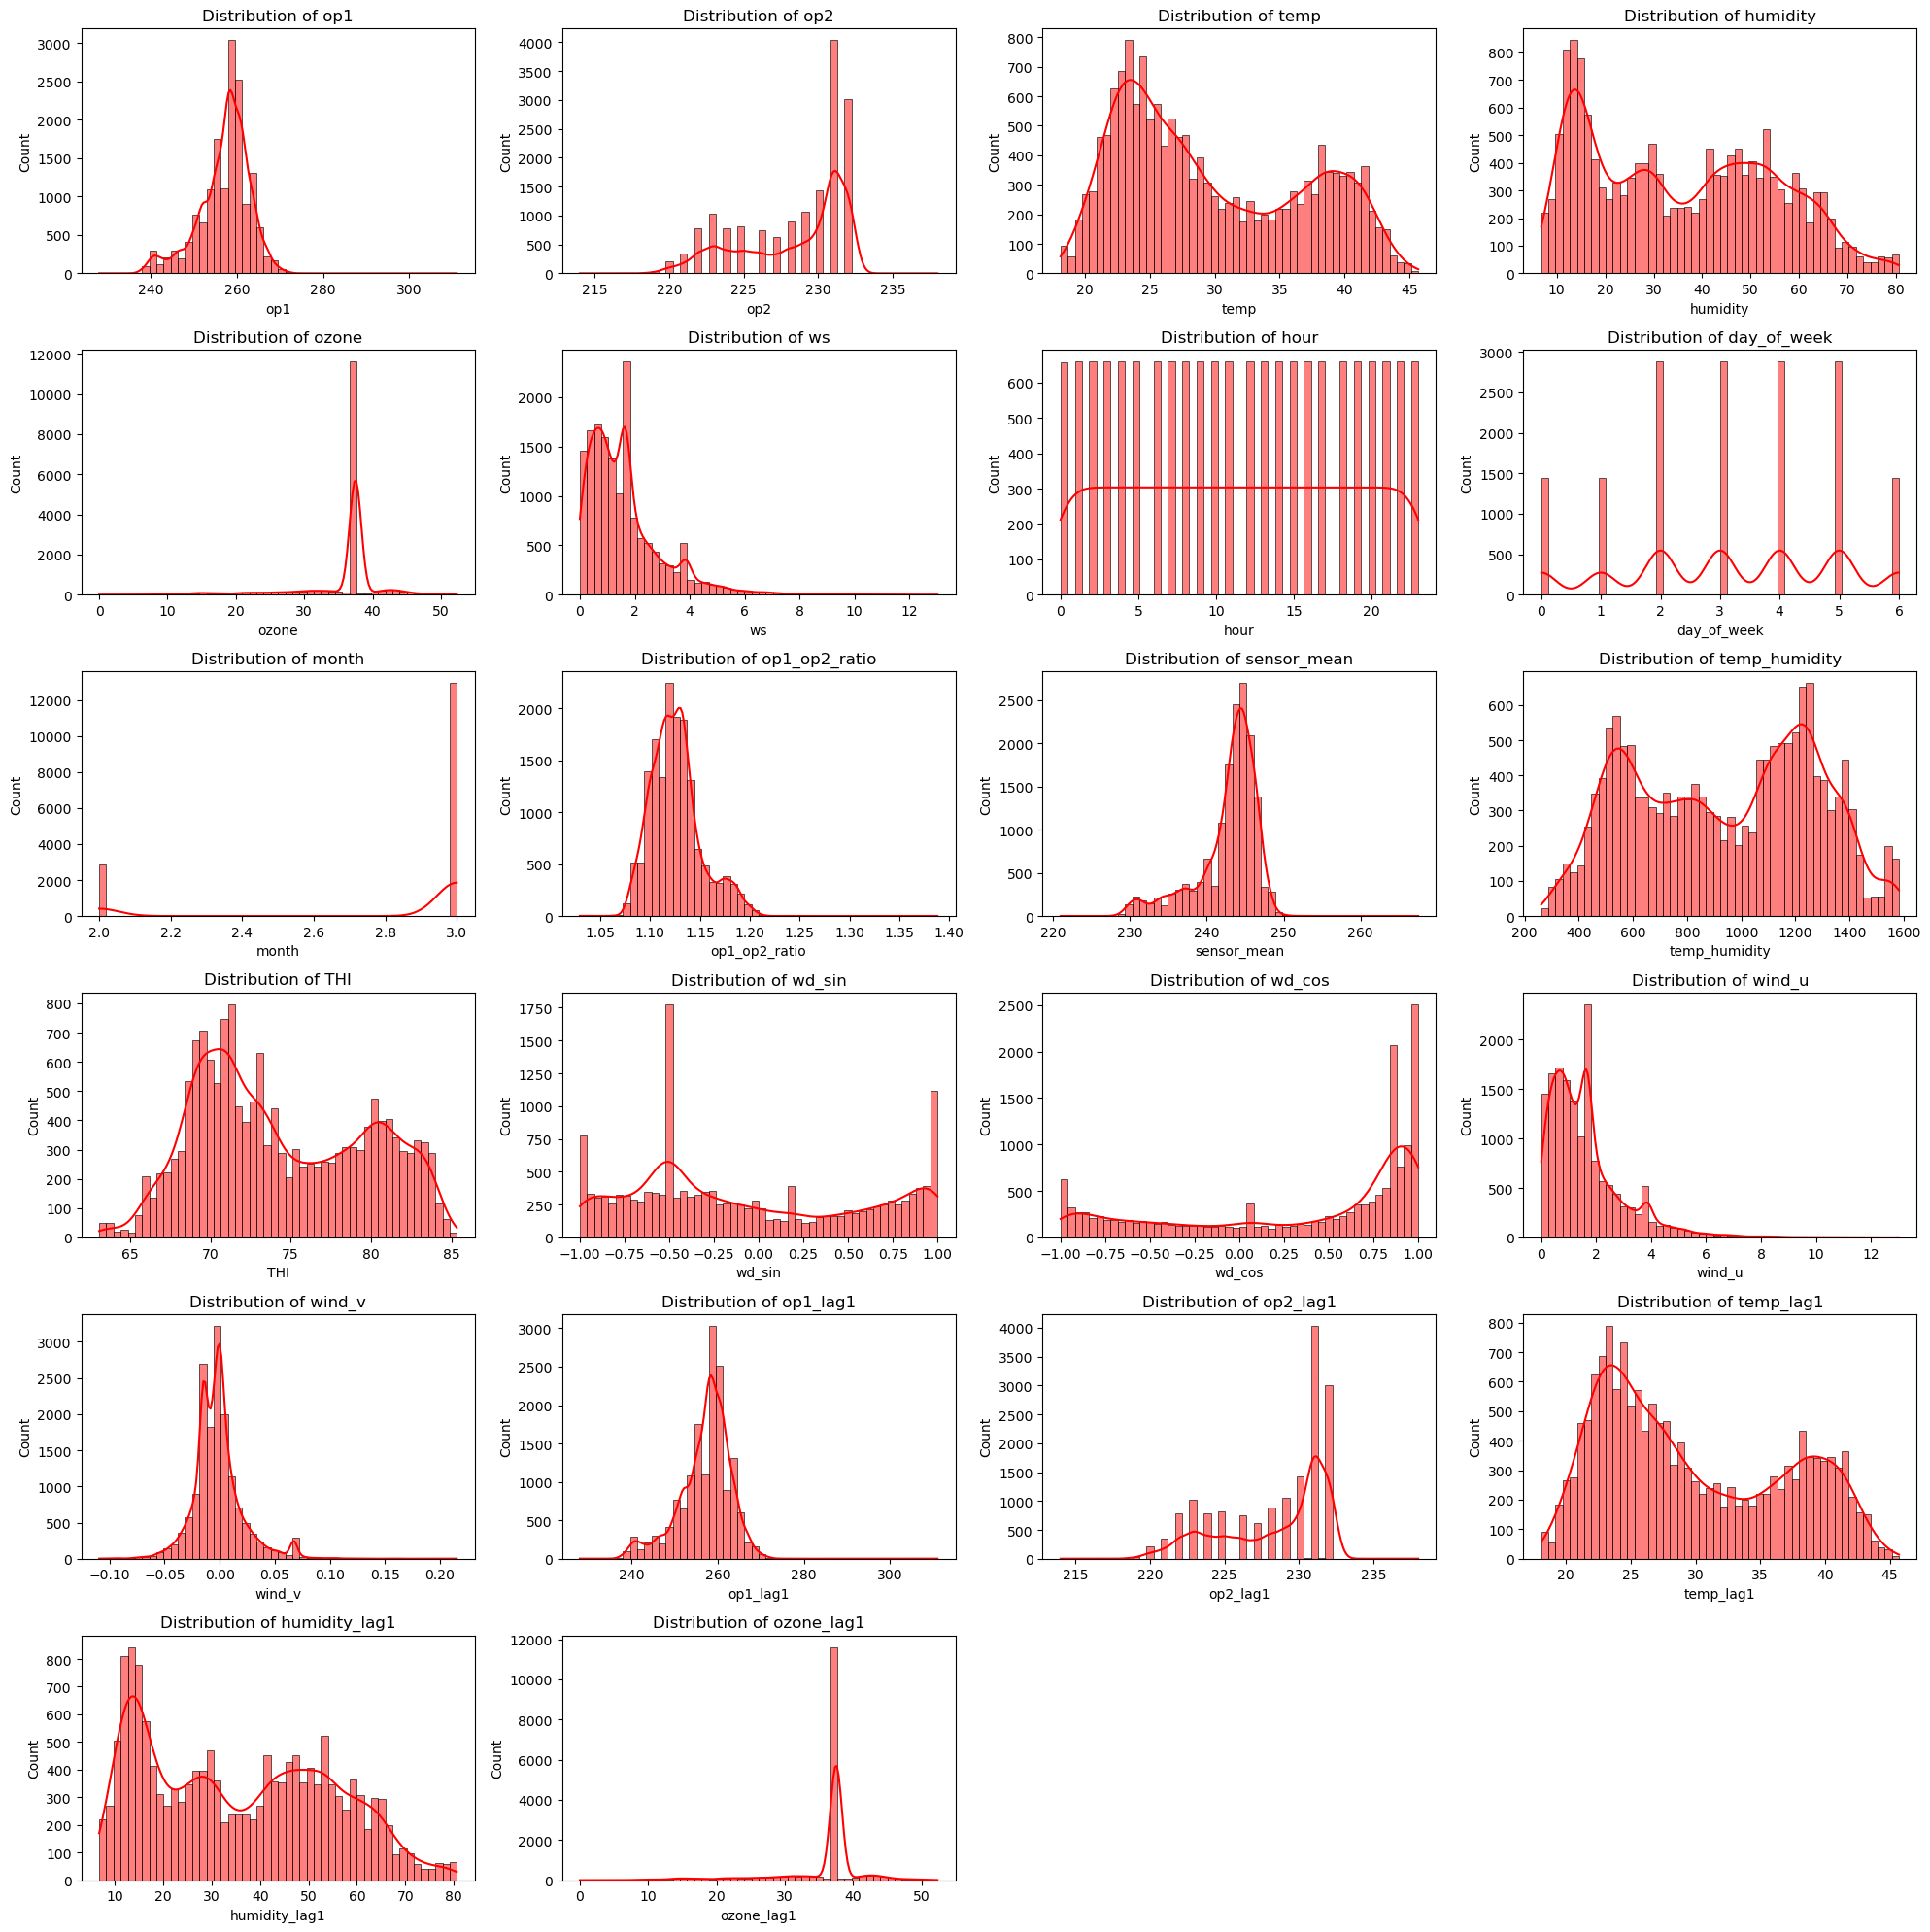

<Axes: >

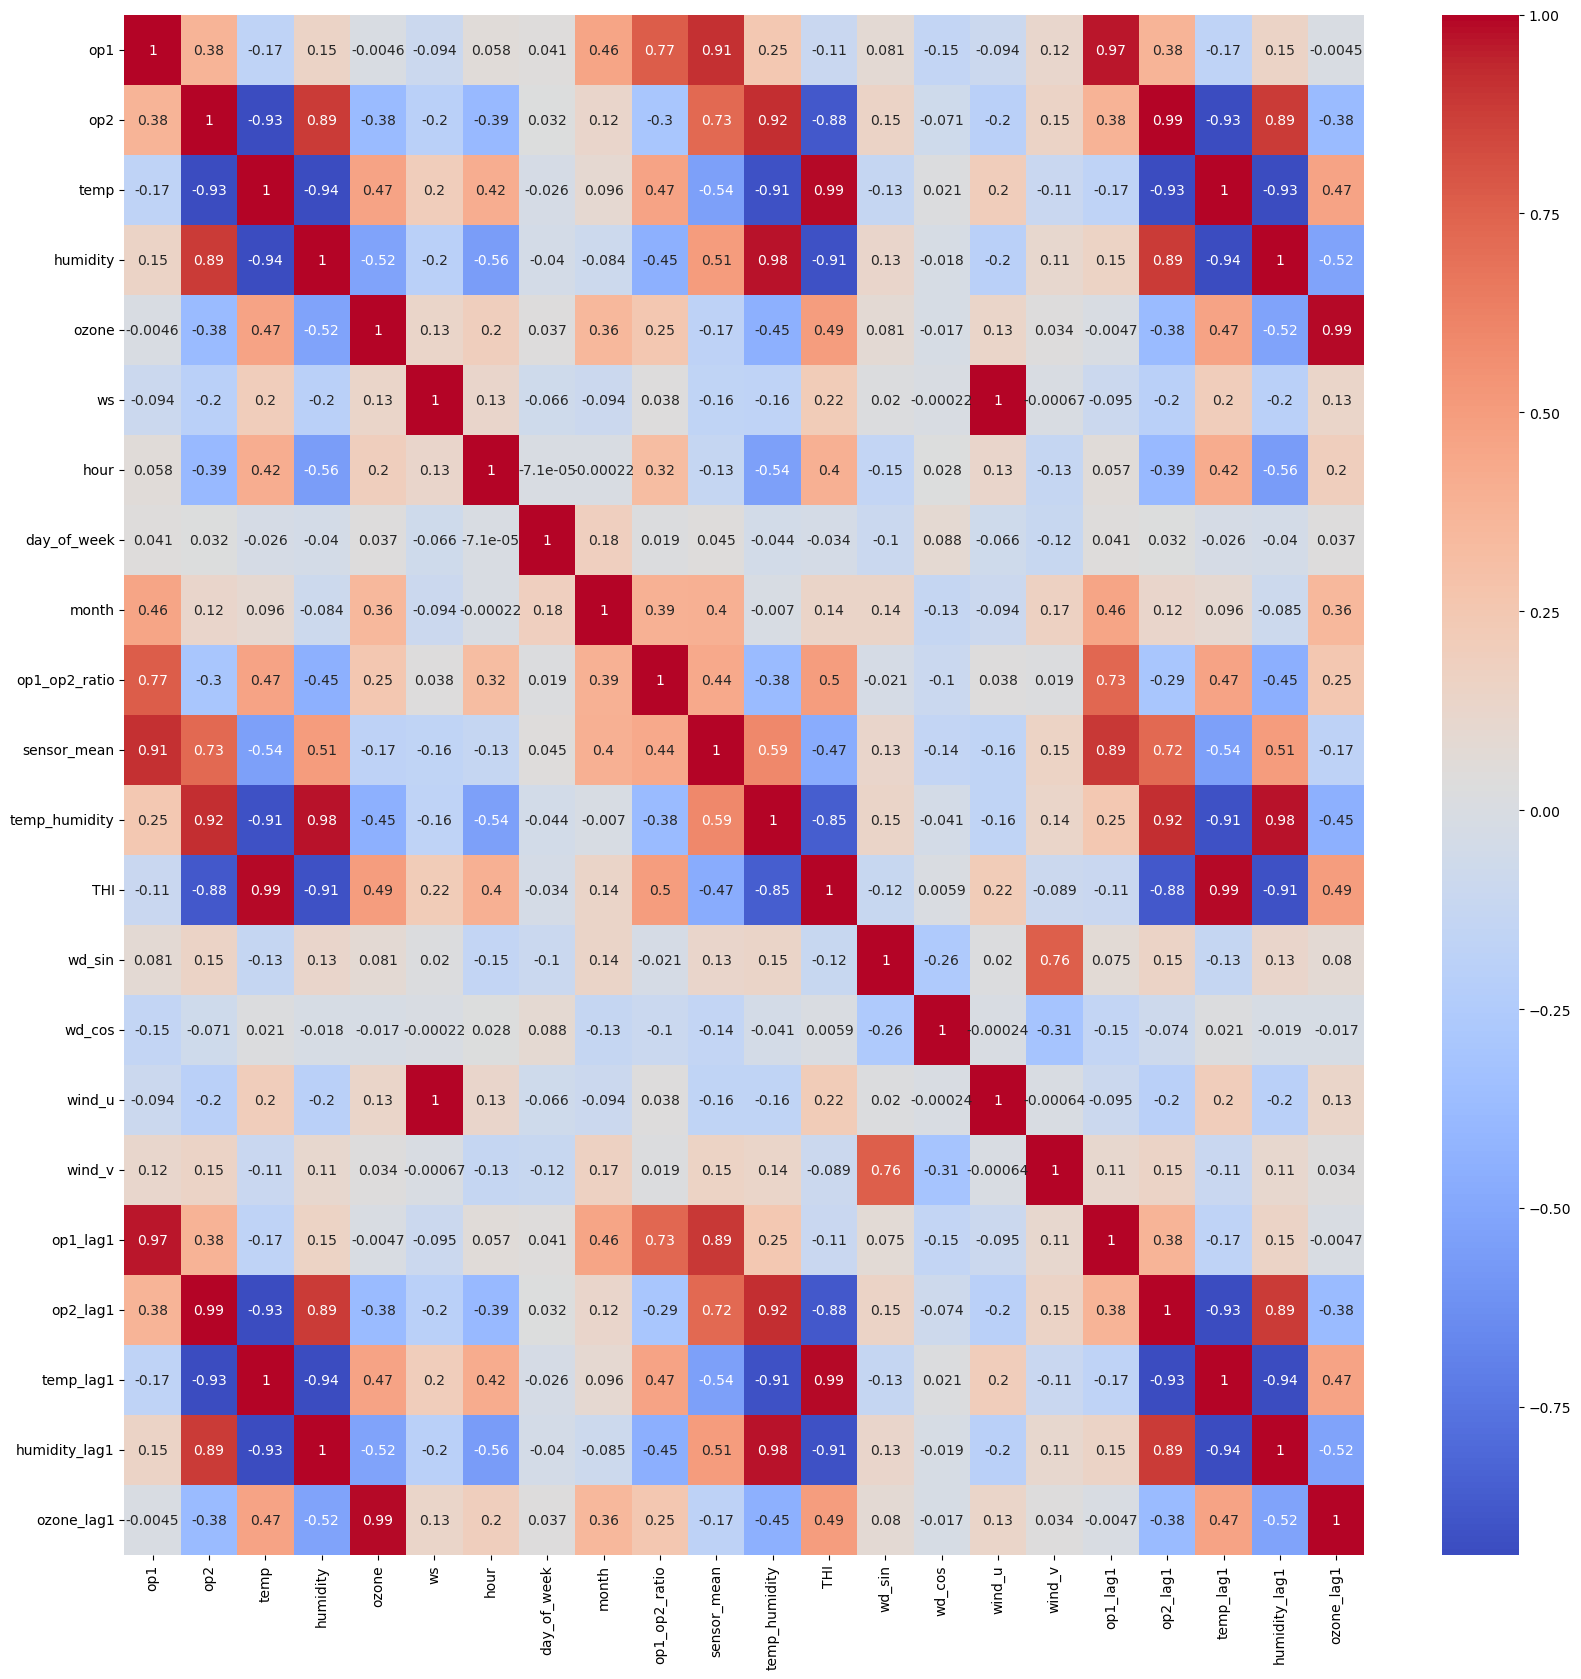

In [13]:
#Statistics Summary
summary_stats = merged_data.describe().transpose()

#Skewness and Kurtosis
skewness_kurtosis = pd.DataFrame({
    'Skewness': merged_data.skew(),
    'Kurtosis': merged_data.kurtosis()
})

#Correlation Matrix 
correlation_matrix = merged_data.corr()

#Visualising 
plt.figure(figsize=(20, 20))
for i, column in enumerate(merged_data.columns, 1):
    plt.subplot(6, 4, i)
    sns.histplot(merged_data[column], kde=True, bins=50,color="Red")
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

(summary_stats, skewness_kurtosis, correlation_matrix['ozone'].sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix,cmap="coolwarm",annot=True)